<a href="https://colab.research.google.com/github/nyct-oph29/FashionGAN/blob/main/fashion_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Bringing in tensorflow
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
# Bringing in tensorflow datasets for fashion mnist
import tensorflow_datasets as tfds
# Bringing in matplotlib for viz stuff
from matplotlib import pyplot as plt


In [3]:
# Use the tensorflow dataset api to bring in the datasets
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompletePOXVCM/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompletePOXVCM/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


## Viz data snd build dataset

In [4]:
# Do some data transformations
import numpy as np

In [5]:
# setup connection aka iterator
dataiterator = ds.as_numpy_iterator()


In [6]:
# Getting data out of the pipeline
dataiterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

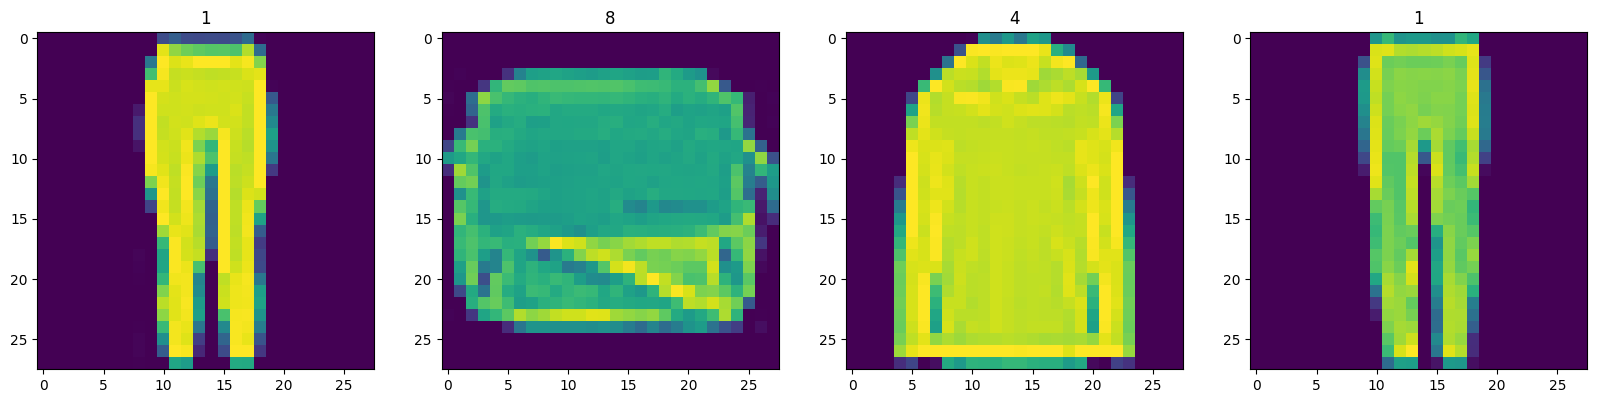

In [7]:
# Setuo the subplot formatting
fig, ax= plt.subplots(ncols=4, figsize=(20,20))
# loop four times and get images
for  idx in range(4):
  # Grab an image and label
  sample = dataiterator.next()
  # Plot the image using a specific subplot
  ax[idx].imshow(np.squeeze(sample['image']))
  # Appending the label to the images
  ax[idx].title.set_text(sample['label'])

In [8]:
# Scale and return images only
def scale_images(data):
  image = data['image']
  return image/ 255

In [9]:
ds = tfds.load('fashion_mnist', split='train')
# Runnning the dataset through the scale_images preprocessing step
ds = ds.map(scale_images)
# Cache the dataset for that batch
ds = ds.cache()
# Shuffle the dataset
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottle necking
ds = ds.prefetch(64)

In [10]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

### BUILDING THE NEURAL NETWORK

In [11]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

BUILDING OUR GENERATOR

In [12]:
def build_generator():
  model = Sequential()
  """
  Takes in random values and reshapes it to 7x7x128
  Beginnings of a generated image
  """
  model.add(Dense(7*7*128, input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  # Upsampling block 1
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  # Upsampling block 2
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  # Convolutional block 1
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  # Convolutional block 2
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  # Adding the final Conv layer to output 1 channel
  model.add(Conv2D(1,4, padding='same', activation='sigmoid'))


  return model

In [13]:
generator = build_generator()

In [14]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

1/1 [==============================] - 2s 2s/step


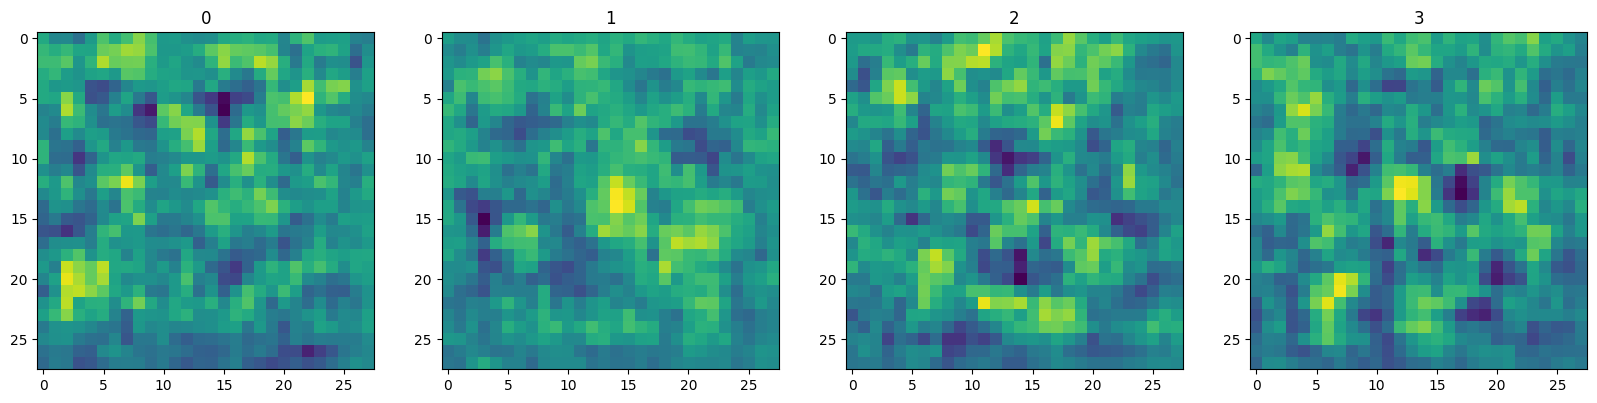

In [15]:
img = generator.predict(np.random.randn(4,128,1))
fig, ax= plt.subplots(ncols=4, figsize=(20,20))
# loop four times and get images
for  idx, img in enumerate(img):

  # Plot the image using a specific subplot
  ax[idx].imshow(np.squeeze(img))
  # Appending the label to the images
  ax[idx].title.set_text(idx)

BUILDING A DISCRIMINATOR

In [16]:
def build_discriminator():
  model = Sequential()

  # First Conv Block
  model.add(Conv2D(32, 5, input_shape=(28,28,1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Second Conv Block
  model.add(Conv2D(64, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Third Conv Block
  model.add(Conv2D(128, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Fourth Conv Block
  model.add(Conv2D(256, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Flatten th emodel and pass it to a dense layer
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [17]:
discriminator = build_discriminator()

In [18]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [19]:
img = generator.predict(np.random.randn(4,128,1))
discriminator.predict(img)

1/1 [==============================] - 0s 359ms/step


array([[0.49690917],
       [0.49689147],
       [0.49693808],
       [0.49696323]], dtype=float32)

### CUSTOM TRAINING LOOP

Setup Losses and Optimizers

In [20]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be th eloss for both
from tensorflow.keras.losses import BinaryCrossentropy

In [21]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

Build Subclassed Model

In [22]:
# IMporting the base model class to subclass our training step
from tensorflow.keras.models import Model

In [23]:
class FashionGAN(Model):
  def __init__(self, generator, discriminator, *args, **kwargs):
    # Pass through args and kwargs to base class
    super().__init__(*args, **kwargs)

    # Create attributes for gen and disc
    self.generator = generator
    self.discriminator = discriminator

  def compile(self, g_opt, g_loss, d_opt, d_loss, *args, **kwargs):
    # Compile with base class
    super().compile(*args, **kwargs)

    # Create atrributes for loss and opt
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss


  def train_step(self, batch):
    # Get the data
    real_images = batch
    fake_images = self.generator(tf.random.normal((128, 128, 1)), training= False)

    # Train the discriminator
    with tf.GradientTape() as d_tape:
      # Pass the real and fake images to the discrminator model
      yhat_real = self.discriminator(real_images, training=True)
      yhat_fake = self.discriminator(fake_images, training=True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

      # Create labels for fake and real images
      y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

      # Add some noise to the TRUE outputs(slows the learning of the discrminator)
      noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real, noise_fake], axis=0)

      # Calculate loss
      total_d_loss = self.d_loss(y_realfake, yhat_realfake)

    # Apply backpropagation - nn learn
    dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

    # training the generator
    with tf.GradientTape() as g_tape:
      # Generate some new images
      gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)

      # Create the prdecited labels
      predicted_labels = self.discriminator(gen_images, training=False)

      # Calculate loss
      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

    # Backpropagation
    ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

    return {'d_loss':total_d_loss, 'g_loss':total_g_loss}








In [24]:
fashgan = FashionGAN(generator, discriminator)

In [25]:
# Complie the model
fashgan.compile(g_opt, g_loss, d_opt, d_loss)

Build Callback

In [26]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback


In [27]:
class ModelMonitor(Callback):
  def __init__(self, num_img=3, latent_dim = 128):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
    random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()
    for i in range(self.num_img):
      img = array_to_img(generated_images[i])
      img.save(os.path.join('images', f'Generated_img_{epoch}_{i}.png'))

Train the model

In [28]:
hist = fashgan.fit(ds, epochs=20)

Epoch 1/20
469/469 [==============================] - 88s 158ms/step - d_loss: 0.4341 - g_loss: 1.2592
Epoch 2/20
469/469 [==============================] - 76s 161ms/step - d_loss: 0.2761 - g_loss: 2.6927
Epoch 3/20
469/469 [==============================] - 77s 164ms/step - d_loss: 0.3311 - g_loss: 5.3535
Epoch 4/20
469/469 [==============================] - 78s 166ms/step - d_loss: 0.2802 - g_loss: 8.7690
Epoch 5/20
469/469 [==============================] - 78s 167ms/step - d_loss: 0.4782 - g_loss: 4.1423
Epoch 6/20
469/469 [==============================] - 79s 167ms/step - d_loss: 0.5941 - g_loss: 0.6754
Epoch 7/20
469/469 [==============================] - 79s 168ms/step - d_loss: 0.4015 - g_loss: 0.3696
Epoch 8/20
469/469 [==============================] - 79s 168ms/step - d_loss: 0.6736 - g_loss: 0.4832
Epoch 9/20
469/469 [==============================] - 79s 168ms/step - d_loss: 0.6860 - g_loss: 0.5603
Epoch 10/20
469/469 [==============================] - 79s 168ms/step - d

1/1 [==============================] - 0s 491ms/step


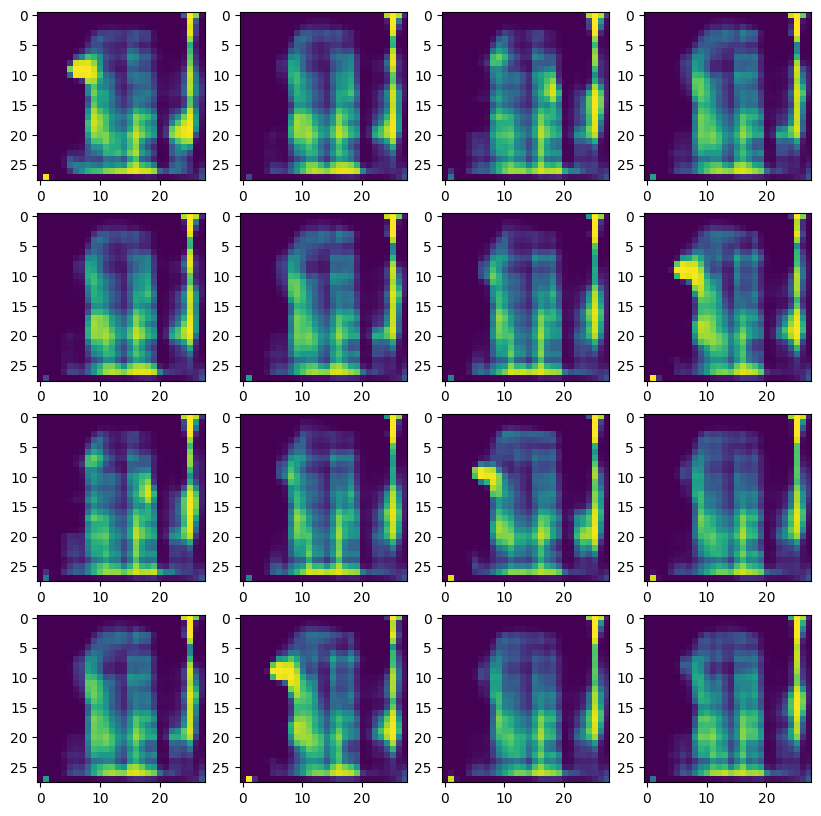

In [29]:
imgs = generator.predict(tf.random.normal((16,128,1)))
fig, ax = plt.subplots(ncols = 4, nrows =4, figsize=(10,10))
for r in range(4):
  for c in range(4):
    ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

In [30]:
!pip install pyyaml h5py

Save the model

In [1]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')

NameError: ignored

In [49]:
generator.load_weights('generator.h5')
discriminator.load_weights('discriminator.h5')

In [50]:
fashgan = FashionGAN(generator, discriminator)
fashgan.compile(g_opt, g_loss, d_opt, d_loss)


In [51]:
hist = fashgan.fit(ds, epochs=40)

Epoch 1/40
469/469 [==============================] - 75s 159ms/step - d_loss: 0.6897 - g_loss: 0.6794
Epoch 2/40
469/469 [==============================] - 76s 163ms/step - d_loss: 0.4244 - g_loss: 0.5093
Epoch 3/40
469/469 [==============================] - 78s 166ms/step - d_loss: 0.5516 - g_loss: 0.5931
Epoch 4/40
469/469 [==============================] - 78s 167ms/step - d_loss: 0.3737 - g_loss: 0.3134
Epoch 5/40
469/469 [==============================] - 79s 168ms/step - d_loss: 0.5382 - g_loss: 0.3907
Epoch 6/40
469/469 [==============================] - 79s 168ms/step - d_loss: 0.7186 - g_loss: 0.5347
Epoch 7/40
469/469 [==============================] - 79s 168ms/step - d_loss: 0.6770 - g_loss: 0.5877
Epoch 8/40
469/469 [==============================] - 79s 168ms/step - d_loss: 0.6054 - g_loss: 0.5896
Epoch 9/40
469/469 [==============================] - 79s 168ms/step - d_loss: 0.6992 - g_loss: 0.5247
Epoch 10/40
469/469 [==============================] - 79s 168ms/step - d

1/1 [==============================] - 0s 17ms/step


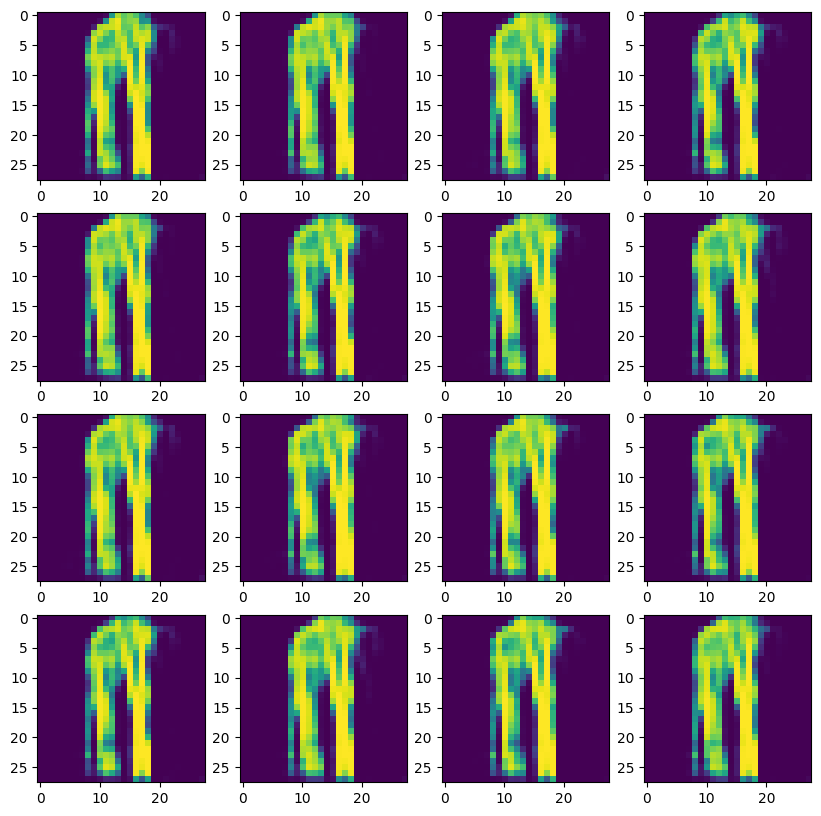

In [52]:
imgs = generator.predict(tf.random.normal((16,128,1)))
fig, ax = plt.subplots(ncols = 4, nrows =4, figsize=(10,10))
for r in range(4):
  for c in range(4):
    ax[r][c].imshow(imgs[(r+1)*(c+1)-1])